# Credit Card Fraud Detection
## Wykrywanie oszustw związanych z kartami kredytowymi


Analizie zostanie poddany zbiór danych zawierający transakcje dokonane kartami kredytowymi we wrześniu 2013r. przez europejczyków w ciągu 2 dni.

Celem zadania jest:

     1) Dokonaj eksploracyjnej analizy danych oraz opisz wnioski i obserwacje;
     2) Stwórz model predykcyjny, który w skuteczny sposób będzie wskazywał podejrzane transakcje;
     3) Dokonać analizy wyników 
     
 Dane pobrane ze strony: https://www.kaggle.com/mlg-ulb/creditcardfraud

## Library - biblioteki 
Wszystkie biblioteki potrzebne do prawidłowego działania kodu znajdują się tutaj.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Introduction - Wprowadzenie 

Na podstawie informacji znajdujących się przy danych wiemy, że tabela zawiera 31 kolumn z pośród których możemy wyszczególnić: 
    - Time - liczba sekund, która upłyneła między badaną tranzakcją a pierwszą transakcją w zestawieniu;
    - Kwota - kwota tranzakcji;
    - Klasa - 1 w przypadku oszustwa, 0 w pozostałych przypadkach
    - V1-V28 - przeskalowane, nieopisane dane w celu ochrony danych osobowych
I każda z kolumn zawiera 

## First look on the data - Podstawowa analiza danych 
### Podsumowanie zdobytych informacji
    1) Rozmiar danych 284807 wierszy, 31 kolumn
    2) 492(0.1723%) transakcje to oszustwa, a pozostałe 284315(99.823%) transakcji to prawidłowe transakcje
    3) Dane nie zawierają żadnych wybrakowanych wartości.
    4) Analiza histogramu oraz boxplota dla zmiennej "Amount" wynika, że mamy doczynienia z bardzo dużą liczbą małych tranzakcji
    5) Analiza histogramu dla zmiennej "Time" można zauważyć, że podczas dnia jest wykonywane zdecydowanie więcej tranzakcji niż nocą;
    

In [2]:
df = pd.read_csv

NameError: name 'pf' is not defined

In [ ]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### Histogram

In [19]:
def draw_histogram(data, title, size=(12,5)):
    '''
        Funkcja do rysowania histogramów
    
    Parameters:
        data: wektor danych, który chcemy zwizualizować przy pomocy histogramu
        title: (str) tytuł wykresu 
        size: rozmiar okna, default=(12,5)
    Return:
        wykres histogramu w nowym oknie
    '''
              
    fig, ax = plt.subplots(figsize=size)
    sns.distplot(data, ax=ax)
    ax.set_title(title)
    ax.set_xlim([min(data), max(data)])
    plt.show() 

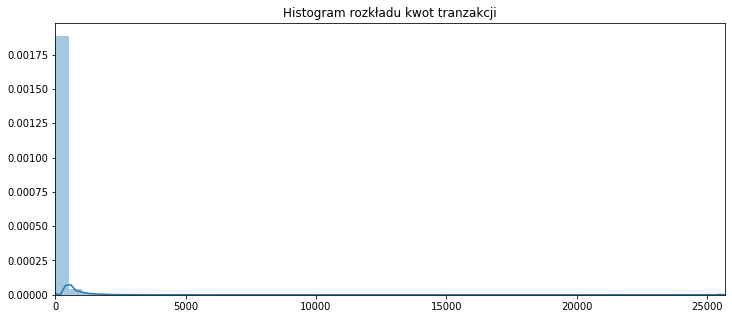

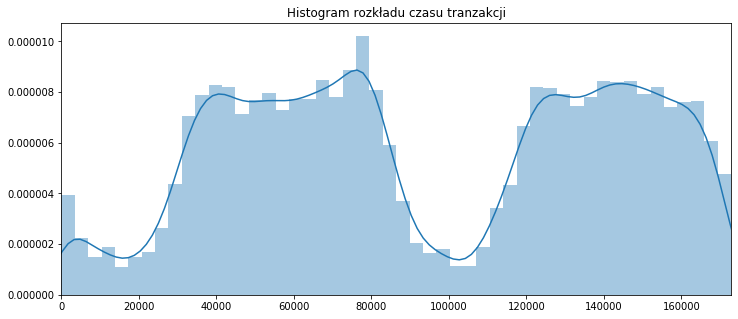

In [21]:
draw_histogram(df.Amount.values, 'Histogram rozkładu kwot tranzakcji')
draw_histogram(df.Time.values, 'Histogram rozkładu czasu tranzakcji')